# Quantifying Crowded Trades(QCT): A Comprehensive Analysis
### sector_relative_value
### Collins Emezie Ugwuozor, Jayesh Chandra Gupta, Emmanuel Effiong Asuquo

In [1]:
#Import the neccessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from pandas_datareader import data
import yfinance as yf
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import yahoo_fin
from yahoo_fin import stock_info

In [2]:
# Pick up table of S&P 500 listed companies from Wikipedia.
data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')

In [3]:
table = data[0]
table.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [4]:
table['GICS Sector'].unique()

array(['Industrials', 'Health Care', 'Information Technology',
       'Consumer Staples', 'Utilities', 'Financials',
       'Consumer Discretionary', 'Materials', 'Real Estate',
       'Communication Services', 'Energy'], dtype=object)

In [5]:
# Select sectors of S&P 500
industrials_sector = table[table['GICS Sector'] == 'Industrials'] # XLI
health_sector = table[table['GICS Sector'] == 'Health Care'] # XLV
tech_sector = table[table['GICS Sector'] == 'Information Technology'] # XLK
consumer_staples_sector = table[table['GICS Sector'] == 'Consumer Staples'] # XLP
utilities_sector = table[table['GICS Sector'] == 'Utilities'] # XLU
financial_sector = table[table['GICS Sector'] == 'Financials'] # XLF
consumer_discretionary_sector = table[table['GICS Sector'] == 'Consumer Discretionary'] # XLY
materials_sector = table[table['GICS Sector'] == 'Materials'] # XLB
real_estate_sector = table[table['GICS Sector'] == 'Real Estate'] # XLRE
communication_services_sector = table[table['GICS Sector'] == 'Communication Services'] # XLC *XTL
energy_sector = table[table['GICS Sector'] == 'Energy'] # XLE

In [6]:
# Define dates for five year historical prices
start_date = "2018-01-01"
end_date = "2023-01-01"

In [7]:
# Sector ETFs for centrality across sectors
symbols = ['XLB', 'XLI', 'XLY', 'XLP', 'XLE', 'XLV', 'XLF', 'XLK', 'XTL', 'XLU', 'XLRE']

In [8]:
# Get the  "Adj Close" data from Yahoo Finance
df_sectors_prices = yf.download(symbols, start=start_date, end=end_date)['Adj Close']
# Calculate daily returns and drop NaNs
df_sectors = df_sectors_prices.pct_change()
df_sectors.dropna(inplace=True)

# Standardize the data and calculate covariance matrix
scaler = StandardScaler()
df_sectors_scaled = scaler.fit_transform(df_sectors)
df_sector_cov = np.cov(df_sectors_scaled.T)

df_sectors.head(10)

[*********************100%%**********************]  11 of 11 completed


,XLB,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY,XTL
Date,,,,,,,,,,,
2018-01-03,0.007004,0.014976,0.005372,0.005386,0.008341,-0.000354,0.000305,-0.007856,0.009568,0.004591,0.000723
2018-01-04,0.008735,0.006036,0.009263,0.007317,0.005055,0.002831,-0.017094,-0.008304,0.001422,0.003279,0.005777
2018-01-05,0.008018,-0.000400,0.002824,0.006875,0.010516,0.004411,0.002174,-0.000389,0.008518,0.007922,0.002154
2018-01-08,0.001432,0.006003,-0.001408,0.004123,0.003771,0.002459,0.006817,0.009351,-0.003636,0.001179,0.009313
2018-01-09,-0.001589,-0.002519,0.007755,0.006415,-0.002555,-0.001402,-0.011388,-0.009844,0.011773,0.001963,-0.006956
2018-01-10,-0.006046,-0.001196,0.008395,-0.000127,-0.003465,-0.004913,-0.015567,-0.010916,-0.001745,-0.000686,-0.012581
2018-01-11,0.013126,0.020495,0.004856,0.012750,0.004082,-0.001410,-0.006325,-0.003745,0.004313,0.016270,0.013899
2018-01-12,0.001580,0.009650,0.008975,0.009316,0.005872,0.000353,-0.007320,-0.005737,0.007661,0.012923,0.009425
2018-01-16,-0.011674,-0.012658,-0.002737,-0.008981,-0.003891,0.004589,0.004809,-0.002189,0.004952,-0.007141,-0.011176


In [9]:
# Sector's Mkt Cap (USD m) picked manually From bloomberg
market_cap = [5150,37211,29320,14101,52475,15373,4368,13622,35850,16512,48]

In [10]:
weights=[]
for i in range(11):
    weights.append(market_cap[i]/(np.array(market_cap)).sum())
weights

[0.022987992679551844,
 0.1660982904075347,
 0.13087532919698255,
 0.06294246306298264,
 0.23423202249698702,
 0.068620274070437,
 0.019497388742579117,
 0.060804356559389365,
 0.1600232111770745,
 0.07370441458733205,
 0.0002142570191492211]

### Relative Value

$$RV_{sector} =  (Sector-Current-Price)/(Sector-200Day-SMA)/(MktCap-weighted-Ave-of Normalized Valuations Across All Sectors) $$

- $RV$ = Relative Value

ACROSS SECTORS:
- We will use the current price of the sector
- The price will be normalize by dividing it by the sector's 200 Day SMA
- We will further divide each sector's current market cap by market cap weighted average of the normalized value of all sectors to establish a cross-sectional relative value measure


In [11]:
# Getting current price of the sector from yahoo finance
sectors = symbols
sector_current_price=[]
for sector in sectors:
    print(sector)
    try:
       sector_current_price.append(yahoo_fin.stock_info.get_live_price(sector))
    except:
        print('Yahoo Finance current price error with: ', sector)

XLB
XLI
XLY
XLP
XLE
XLV
XLF
XLK
XTL
XLU
XLRE


In [12]:
sector_current_price

[80.7699966430664,
 106.08000183105469,
 168.0800018310547,
 70.1500015258789,
 84.58000183105469,
 130.42999267578125,
 35.27000045776367,
 184.77000427246094,
 69.80000305175781,
 62.529998779296875,
 36.18000030517578]

In [13]:
# Getting sector's 200 Day SMA from yahoo finance
sectors = symbols
sector_200DaySMA=[]
for sector in sectors:
    print(sector)
    try:
       sector_200DaySMA.append(yahoo_fin.stock_info.get_data(sector, interval='1d')['close'][-200:].mean())
    except:
        print('Sector_200DaySMA error with: ', sector)

XLB
XLI
XLY
XLP
XLE
XLV
XLF
XLK
XTL
XLU
XLRE


In [14]:
sector_200DaySMA

[80.0763500213623,
 102.76035026550294,
 157.83829925537108,
 72.72189990997315,
 84.7016502380371,
 130.77245048522948,
 33.598299999237064,
 161.539400100708,
 74.30874996185302,
 64.80655012130737,
 36.55230001449585]

In [15]:
#Normalized by dividing it's current price with the sector's 200 Day SMA
normalize=[]
for i in range(11):
    normalize.append(sector_current_price[i]/sector_200DaySMA[i])
normalize

[1.0086623156714694,
 1.032304790290951,
 1.064887309505998,
 0.9646337844957551,
 0.9985638012170891,
 0.9973812694632734,
 1.049755507229966,
 1.143807666471897,
 0.9393241453744032,
 0.9648715857000696,
 0.9898146023869244]

In [16]:
weights=[]
for i in range(11):
    weights.append(normalize[i] * (np.array(market_cap)).sum()/(np.array(market_cap)).sum())
weights

[1.0086623156714694,
 1.032304790290951,
 1.064887309505998,
 0.9646337844957551,
 0.9985638012170891,
 0.9973812694632733,
 1.049755507229966,
 1.143807666471897,
 0.9393241453744032,
 0.9648715857000696,
 0.9898146023869244]

In [17]:
weights = np.array(weights)
weighted_average = weights.mean()

In [18]:
# Establish a cross-sectional relative value measure
relative_measure=[]
for i in range(11):
    relative_measure.append(normalize[i]/weighted_average)
relative_measure

[0.9947354070522471,
 1.0180514428046847,
 1.0501840852268332,
 0.9513147912519719,
 0.9847763258708372,
 0.9836101216940698,
 1.0352612123657976,
 1.1280147647232919,
 0.9263546100470625,
 0.9515493090624384,
 0.9761479299007636]

In [19]:
relative_scores = dict(zip(symbols, [np.around(r,3) for r in relative_measure]))

In [20]:
relative_scores

{'XLB': 0.995,
 'XLI': 1.018,
 'XLY': 1.05,
 'XLP': 0.951,
 'XLE': 0.985,
 'XLV': 0.984,
 'XLF': 1.035,
 'XLK': 1.128,
 'XTL': 0.926,
 'XLU': 0.952,
 'XLRE': 0.976}

In [21]:
# Create a dataframe of computed scores
for asset in relative_scores:
    relative_scores[asset] = [relative_scores[asset]]
scores_df = pd.DataFrame(data = relative_scores, index=['Weighted_score'])
scores_df

,XLB,XLI,XLY,XLP,XLE,XLV,XLF,XLK,XTL,XLU,XLRE
Weighted_score,0.995,1.018,1.05,0.951,0.985,0.984,1.035,1.128,0.926,0.952,0.976


In [22]:
# Define relative values for each sector
relative_values = np.array([0.995,	1.018,	1.05,	0.951,	0.985,	0.984,	1.035,	1.128,	0.926,	0.952, 0.976])
# Create a dictionary with sector names and their corresponding relative values
sector_relative_values = dict(zip(df_sectors.columns, relative_values))

# Create a copy of the original DataFrame
weighted_df = df_sectors.copy()

# Iterate over each sector
for sector in df_sectors.columns:
    # Multiply the returns in each sector by the square root of its relative value
    weighted_df.loc[:, sector] = weighted_df.loc[:, sector] * sector_relative_values[sector] ** 0.5

# Display the first few rows of the resulting DataFrame
weighted_df.head()

,XLB,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY,XTL
Date,,,,,,,,,,,
2018-01-03,0.006987,0.015110,0.005505,0.005252,0.008279,-0.000351,0.000311,-0.008344,0.009207,0.004480,0.000714
2018-01-04,0.008713,0.006090,0.009492,0.007136,0.005017,0.002808,-0.017390,-0.008820,0.001368,0.003199,0.005707
2018-01-05,0.007998,-0.000404,0.002893,0.006704,0.010437,0.004375,0.002212,-0.000413,0.008196,0.007730,0.002128
2018-01-08,0.001428,0.006056,-0.001443,0.004021,0.003743,0.002439,0.006936,0.009932,-0.003499,0.001151,0.009201
2018-01-09,-0.001585,-0.002542,0.007946,0.006256,-0.002535,-0.001391,-0.011586,-0.010455,0.011329,0.001915,-0.006872


In [23]:
# Calculate rolling 1-year relative scores
rolling_relative_scores = weighted_df.rolling(window=252).mean()

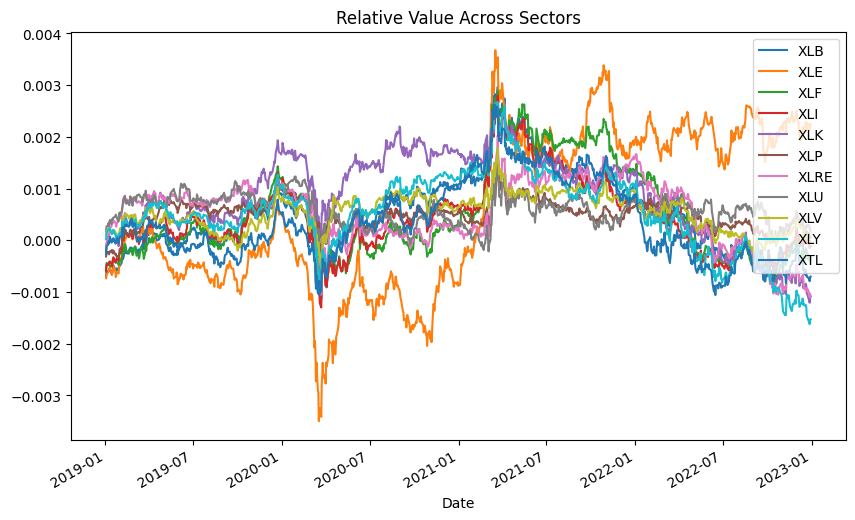

In [24]:
# Plot the relative values
rolling_relative_scores.plot(figsize=(10, 6), title='Relative Value Across Sectors')
# Show the plot
plt.show()